In [832]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.decomposition import PCA

from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import random
import tensorflow as tf

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [833]:
def get_initial_11(team):
    base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'
    team_data_path = os.path.join(base_path, team, f'{team}_summary.csv')
    try:
        df = pd.read_csv(team_data_path)
        df = df.drop_duplicates()
        df = df.sort_values(by='MinutesPlayed', ascending=False)
        return df['PlayerName'][:11].tolist()
    except FileNotFoundError:
        print(f'Error: El archivo {team}_summary.csv no se encontró en la carpeta de {team}.')
        return None
    except Exception as e:
        print(f'Error al cargar el archivo para {team}: {str(e)}')
        return None

## Top 15
Nos sirve para tener mas jugadores para entrenar, no nos interesan todos porque hay algunos que juegan muy poco y pueden cambiar mucho los resultados pero el top 15 suele ser el que mas participa

In [834]:
def get_frequent_15(team):
    base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'
    team_data_path = os.path.join(base_path, team, f'{team}_summary.csv')
    try:
        df = pd.read_csv(team_data_path)
        df = df.drop_duplicates()
        df = df.sort_values(by='MinutesPlayed', ascending=False)
        return df['PlayerName'][:15].tolist()
    except FileNotFoundError:
        print(f'Error: El archivo {team}_summary.csv no se encontró en la carpeta de {team}.')
        return None
    except Exception as e:
        print(f'Error al cargar el archivo para {team}: {str(e)}')
        return None

In [835]:
def get_team_players(team):
    base_path = '//Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'
    team_data_path = os.path.join(base_path, team, f'{team}_summary.csv')
    try:
        df = pd.read_csv(team_data_path)
        df = df.drop_duplicates()
        df = df.sort_values(by='MinutesPlayed', ascending=False)
        return df['PlayerName'].tolist()
    except FileNotFoundError:
        print(f'Error: El archivo {team}_summary.csv no se encontró en la carpeta de {team}.')
        return None
    except Exception as e:
        print(f'Error al cargar el archivo para {team}: {str(e)}')
        return None

In [836]:
def load_player_matrix(team_name, player_name, matrix_name):
    base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'
    if matrix_name != 'pass_transition_matrix':
        matrix_path = os.path.join(base_path, team_name, player_name, f'{matrix_name}.csv')
        matrix = np.loadtxt(matrix_path, delimiter=',')
    else:
        matrix_path = os.path.join(base_path, team_name, player_name, f'{matrix_name}.npy')
        matrix = np.load(matrix_path)
    return matrix

In [837]:
def aggregate_team_matrices(team, players):
    team_matrixes = {
        'pass_matrix':  np.zeros((10, 10)),
        'shot_matrix': np.zeros((10, 10)),
        'defense_matrix': np.zeros((10, 10)),
        'goal_matrix': np.zeros((10, 10)),
        'errors_matrix': np.zeros((10, 10)),
        'out_matrix': np.zeros((10, 10))
    }

    for player in players:
        team_matrixes['pass_matrix'] += load_player_matrix(team, player, 'pass_matrix')
        team_matrixes['shot_matrix'] += load_player_matrix(team, player, 'shot_matrix')
        team_matrixes['defense_matrix'] += load_player_matrix(team, player, 'defense_matrix')
        team_matrixes['goal_matrix'] += load_player_matrix(team, player, 'goal_matrix')
        team_matrixes['errors_matrix'] += load_player_matrix(team, player, 'errors_matrix')
        team_matrixes['out_matrix'] += load_player_matrix(team, player, 'out_matrix') 
    
    return team_matrixes

In [838]:
teams_list = ['Arsenal', 'Everton', 'Fulham', 'Manchester City',
       'Newcastle United', 'Queens Park Rangers', 'Reading',
       'West Bromwich Albion', 'West Ham United', 'Wigan Athletic',
       'Aston Villa', 'Chelsea', 'Liverpool', 'Manchester United',
       'Norwich City', 'Southampton', 'Stoke City', 'Sunderland',
       'Swansea City', 'Tottenham Hotspur']

## Construccion del dataframe con informacion de jugadores

In [839]:
base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'

team_matrixes = {}
player_matrixes = {}
all_players = []

for team in teams_list:
    team_csv_path = os.path.join(base_path, f"{team}/{team}_summary.csv")
    team_data = pd.read_csv(team_csv_path)
    
    players = get_frequent_15(team) 
    for player in players:
        if player not in player_matrixes:
            player_matrixes[player] = {}
        
        types = {
           
            'pass_matrix':  np.zeros((10, 10)),
            'shot_matrix': np.zeros((10, 10)),
            'defense_matrix': np.zeros((10, 10)),
            'goal_matrix': np.zeros((10, 10)),
            'errors_matrix': np.zeros((10, 10)),
            'out_matrix': np.zeros((10, 10))
        }
        
        all_players.append(player)
        
        for type_name in types:
            
            player_matrixes[player][type_name] = load_player_matrix(team, player, type_name)
        
        player_info = team_data[team_data['PlayerName'] == player]
        if not player_info.empty:
            position = player_info['Position'].values[0]
            cards = player_info['Cards'].values[0]
            time_played = player_info['MinutesPlayed'].values[0]
            player_matrixes[player]['team'] = team
            player_matrixes[player]['position'] = position
            player_matrixes[player]['cards'] = cards
            player_matrixes[player]['time'] = time_played

    team_matrixes[team] = aggregate_team_matrices(team, players)

In [840]:
for team in teams_list:
    for matrix in team_matrixes[f'{team}']:
        team_matrixes[f'{team}'][matrix] = np.sum(team_matrixes[f'{team}'][matrix] * 90)

In [841]:
for player in all_players:
    for matrix_name, matrix_value in player_matrixes[f'{player}'].items():
        if matrix_name == 'cards':
            player_matrixes[f'{player}'][matrix_name] = matrix_value * 90
        elif matrix_name == 'time':
            player_matrixes[f'{player}'][matrix_name] = matrix_value / 90
        elif matrix_name == 'position' or matrix_name == 'team':
            pass
        else:
            player_matrixes[f'{player}'][matrix_name] = np.sum(matrix_value * 90)

In [842]:
player_dataframe = pd.DataFrame(player_matrixes).T

In [843]:
player_dataframe

,pass_matrix,shot_matrix,defense_matrix,goal_matrix,errors_matrix,out_matrix,team,position,cards,time
"Cazorla, Santiago",56.60181,3.02211,10.14408,0.31536,3.75804,2.81196,Arsenal,Midfielder,0.026277,38.055556
"Mertesacker, Per",43.94241,0.47952,10.52028,0.08451,4.31514,1.35297,Arsenal,Defender,0.112817,35.455556
"Arteta, Mikel",73.21698,0.55062,13.47732,0.17388,4.23117,1.5939,Arsenal,Midfielder,0.173913,34.5
"Giroud, Olivier",16.45299,3.92085,7.73109,0.40302,7.73145,3.11355,Arsenal,Striker,0.14658,27.288889
"Walcott, Theo",17.0568,3.28293,4.60359,0.5283,2.30157,2.15019,Arsenal,Striker,0.113208,26.5
...,...,...,...,...,...,...,...,...,...,...
"Adebayor, Emmanuel",26.06058,2.16747,5.46957,0.25794,5.67621,1.85697,Tottenham Hotspur,Striker,0.206422,19.377778
"Caulker, Steven",31.83048,0.7605,13.03704,0.10863,7.76835,3.20607,Tottenham Hotspur,Defender,0.0,18.411111
"Gallas, William",31.17726,0.33642,13.85001,0.05607,5.27067,2.69136,Tottenham Hotspur,Defender,0.11215,17.833333
"Parker, Scott",49.68306,0.94932,14.42943,0.0,4.61925,2.7207,Tottenham Hotspur,Midfielder,0.063291,15.8


## Agregado de metricas de participación

In [844]:
for team in teams_list:
    team_stats = team_matrixes[team]
    for player in get_frequent_15(team):
        if player in player_dataframe.index:
            for stat_name, stat_value in team_stats.items():
                player_dataframe.loc[player, f'{stat_name}_team'] = stat_value

In [845]:
metrics = ['pass_matrix', 'shot_matrix', 'defense_matrix', 'goal_matrix', 'errors_matrix', 'out_matrix']

for metric in metrics:
    player_dataframe[f'{metric}_contribution'] = player_dataframe[metric] / player_dataframe[f'{metric}_team']

In [846]:
player_dataframe = player_dataframe.round(2)

In [847]:
player_dataframe = player_dataframe.reset_index().rename(columns={'index': 'player'})

## Agregamos la variable a predecir: el ranking

In [848]:
ranking = pd.read_excel('/Users/luisalawson/Desktop/Ranking.xlsx')

In [849]:
player_dataframe = player_dataframe.merge(ranking[['Equipo', 'Posicion']], left_on='team', right_on='Equipo', how='left')
player_dataframe = player_dataframe.drop(columns=['Equipo'])
player_dataframe = player_dataframe.rename(columns={'Posicion': 'TeamRanking'})

## Modelo clasificador

In [850]:
player_dataframe['TeamRanking'] = player_dataframe['TeamRanking'].apply(lambda x: 0 if x <= 4 else (1 if x <= 8 else (2 if x <= 12 else (3 if x <= 16 else 4))))

In [851]:
# Si queremos que sean 3 clases (probar mas adelante, ya probe y no dio tanta diferencia, mejor 5)

# player_dataframe['TeamRanking'] = player_dataframe['TeamRanking'].apply(
#     lambda x: 0 if x <= 6 else (1 if x <= 13 else 2)
# )

In [852]:
# eliminamos el nombre (no me aporta en nada), el equipo (porque se correlaciona con el ranking y seria data leak) 
# y el team Ranking porque es lo que queremos predecir
X = player_dataframe.drop(columns=['player', 'team', 'TeamRanking'])
# nos quedamos con la variable a predecir
y = player_dataframe['TeamRanking']

In [853]:
# la posicion la pasamos a One Hot encoding porque son categoricas y no nos sirve tenerla asi
X = pd.get_dummies(X, columns=['position'], prefix='position')
# drop de las variables de equipo porque tambien se correlaciona con el ranking (mismos jugadores del mismo equipo tienen esto igual) y 
# estariamos haciendo data leak
X = X.drop(columns = ['pass_matrix_team',
       'shot_matrix_team', 'defense_matrix_team', 'goal_matrix_team',
       'errors_matrix_team', 'out_matrix_team'])

In [854]:
# primero normalizamos los valores (le sirve a los modelos para predecir tener los nros en un rango mas chico creo)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# separamos en los datasets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# PROBAR MODELOS ACA - Poner los valores de accuracy asi vamos teniendo info 
# (lo puse en la celda que sigue para no tener muy largo aca), si cambiamos uno pegar el viejo en la de abajo, 
# poner los nros y dejar el que probamos aca

# accuracy: 0.9124 - val_accuracy: 0.4792 - test_accuracy: 0.4799
model = models.Sequential([
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    #si cambiamos la agrupacion del ranking cambiar en el out de esta
    layers.Dense(5, activation='softmax')  
])

# aca podemos probar con optimizadores pero la loss mantenerla igual x ser categorica (no usar mse)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# probar con patience, esto es si no me mejora la val_loss en 20 iteraciones dejar (xq seguro esta haciendo 
# overfitting o ya no puede levantar mas patrones)
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# entrenamos al modelo - probar con epoch y batch size para ver si cambia en algo
history = model.fit(X_train, y_train, epochs=200, batch_size=32, 
                    validation_split=0.2, callbacks=[early_stopping])

Epoch 1/200


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.1642 - loss: 2.8844 - val_accuracy: 0.2292 - val_loss: 2.7214
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2253 - loss: 2.7613 - val_accuracy: 0.2292 - val_loss: 2.6780
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2827 - loss: 2.6215 - val_accuracy: 0.1875 - val_loss: 2.6449
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2750 - loss: 2.5767 - val_accuracy: 0.1667 - val_loss: 2.6151
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2696 - loss: 2.5454 - val_accuracy: 0.1875 - val_loss: 2.5789
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3347 - loss: 2.4981 - val_accuracy: 0.1875 - val_loss: 2.5405
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3405 - loss: 2.4436 - val_accuracy: 0.2292 - val_loss: 2.5014
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3396 - loss: 2.3826 - val_accuracy: 0.2708 - val_loss: 2.4646
Epoc

In [772]:
## MODELOS QUE YA PROBAMOS

# val_acc -> 0.5833 | acc -> 0.9443 | test_acc -> 0.3669
# model = models.Sequential([
#     layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)),
#     layers.Dropout(0.2),
#     layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     layers.Dropout(0.1),
#     layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#si cambiamos la agrupacion del ranking cambiar en el out de esta
#     layers.Dense(5, activation='softmax')
# ])

# estas acaaaaa !!!!!
# model = models.Sequential([
#     layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)),
#     layers.Dropout(0.3),
#     layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     layers.Dropout(0.2),
#     layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     layers.BatchNormalization(),
#si cambiamos la agrupacion del ranking cambiar en el out de esta
#     layers.Dense(5, activation='softmax')
# ])


# val_acc -> 0.27 | acc -> 0.6
# model = models.Sequential([
#     layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.02), input_shape=(X_train.shape[1],)),
#     layers.Dropout(0.4),
#     layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.02)),
#     layers.Dropout(0.3),
#si cambiamos la agrupacion del ranking cambiar en el out de esta
#     layers.Dense(5, activation='softmax')  
# ])

# val_acc -> 0.22 | acc -> 0.4

# model = models.Sequential([
#     layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)),
#     layers.Dropout(0.3),
#     layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     layers.Dropout(0.2),
#si cambiamos la agrupacion del ranking cambiar en el out de esta
#     layers.Dense(5, activation='softmax')  
# ])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4799 - loss: 1.5670
Test Accuracy: 0.52


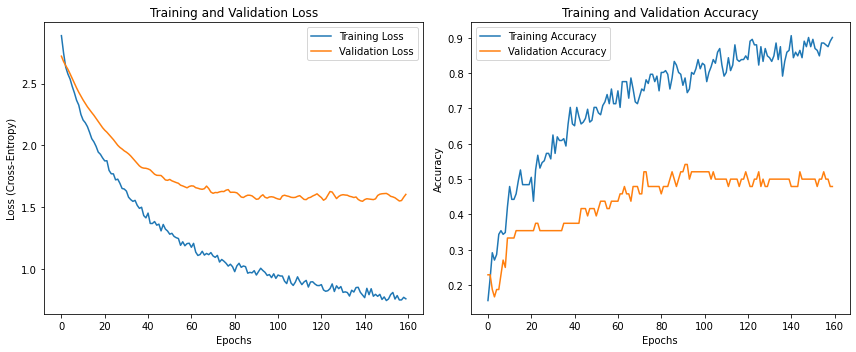

In [855]:
# Vemos como da en test
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

# graficos de accuracy y de loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross-Entropy)')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [856]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test MAE: {test_loss}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4799 - loss: 1.5670
Test MAE: 1.5032387971878052


## Probando el ranking en base al modelo

In [857]:
team_rankings_pred = {}

for team in teams_list:
    players = get_initial_11(team)
    player_predictions = []

    for player in players:
        if player in player_matrixes:
            player_row = player_dataframe[player_dataframe['player'] == player].copy()
            required_columns = [
                'pass_matrix', 'shot_matrix', 'defense_matrix', 'goal_matrix', 
                'errors_matrix', 'out_matrix', 'cards', 'time',
                'pass_matrix_contribution', 'shot_matrix_contribution', 
                'defense_matrix_contribution', 'goal_matrix_contribution', 
                'errors_matrix_contribution', 'out_matrix_contribution'
            ]
            position_columns = [
                'position_Defender', 'position_Goalkeeper', 'position_Midfielder', 
                'position_Striker'
            ]

            player_position = player_row['position'].values[0]
            for pos_col in position_columns:
                player_row.loc[:, pos_col] = 1 if player_position in pos_col else 0

            player_row = player_row[required_columns + position_columns]

            player_features = pd.DataFrame(player_row[required_columns + position_columns])
            player_features = scaler.transform(player_features)

            player_prediction = model.predict(player_features)
            predicted_class = np.argmax(player_prediction[0])

            player_predictions.append(predicted_class)
        else:
            print(f"Player {player} not found in player_matrixes")

    # Average predictions
    if player_predictions:
        team_rankings_pred[team] = np.mean(player_predictions)
    else:
        print(f"No predictions for team {team}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

In [858]:
team_rankings_pred_df = pd.DataFrame(team_rankings_pred.items(), columns=['Team', 'PredictedRanking'])

In [859]:
team_rankings_pred_df

,Team,PredictedRanking
0,Arsenal,0.181818
1,Everton,0.909091
2,Fulham,1.909091
3,Manchester City,0.090909
4,Newcastle United,2.909091
5,Queens Park Rangers,3.545455
6,Reading,3.727273
7,West Bromwich Albion,1.272727
8,West Ham United,2.363636
9,Wigan Athletic,3.636364


In [860]:
team_rankings_pred_df.sort_values(by='PredictedRanking', ascending=True)
team_rankings_pred_df = team_rankings_pred_df.merge(ranking[['Equipo', 'Posicion']], left_on='Team', right_on='Equipo', how='left')
team_rankings_pred_df['Real'] = team_rankings_pred_df['Posicion'].apply(lambda x: 0 if x <= 4 else (1 if x <= 8 else (2 if x <= 12 else (3 if x <= 16 else 4))))
# si hacemos con 3 descomentar la de abajo y comentar la de arriba
# team_rankings_pred_df['Real'] = team_rankings_pred_df['Posicion'].apply(
#     lambda x: 0 if x <= 6 else (1 if x <= 13 else 2)
# )

team_rankings_pred_df = team_rankings_pred_df.rename(columns={'PredictedRanking': 'Predicted'})


team_rankings_pred_df['diff'] = team_rankings_pred_df['Real'] - team_rankings_pred_df['Predicted']
team_rankings_pred_df = team_rankings_pred_df[['Team', 'Predicted', 'Real', 'diff']]

In [861]:
team_rankings_pred_df.sort_values(by='Predicted', ascending=True)

,Team,Predicted,Real,diff
3,Manchester City,0.090909,0,-0.090909
0,Arsenal,0.181818,0,-0.181818
11,Chelsea,0.181818,0,-0.181818
13,Manchester United,0.272727,0,-0.272727
12,Liverpool,0.636364,1,0.363636
1,Everton,0.909091,1,0.090909
19,Tottenham Hotspur,1.000000,1,0.000000
7,West Bromwich Albion,1.272727,1,-0.272727
18,Swansea City,1.818182,2,0.181818
2,Fulham,1.909091,2,0.090909


## Player swap
#### van Persie, Robin -> Mackie, Jamie

In [862]:
team_rankings_pred = {}

for team in teams_list:
    players = get_initial_11(team)
    if team == 'Manchester United' and 'van Persie, Robin' in players:
        players = [player if player != 'van Persie, Robin' else 'Mackie, Jamie' for player in players]
    
    if team == 'Queens Park Rangers' and 'Mackie, Jamie' in players:
        players = [player if player != 'Mackie, Jamie' else 'van Persie, Robin' for player in players]
        
    player_predictions = []

    for player in players:
        if player in player_matrixes:
            player_row = player_dataframe[player_dataframe['player'] == player].copy()
            required_columns = [
                'pass_matrix', 'shot_matrix', 'defense_matrix', 'goal_matrix', 
                'errors_matrix', 'out_matrix', 'cards', 'time',
                'pass_matrix_contribution', 'shot_matrix_contribution', 
                'defense_matrix_contribution', 'goal_matrix_contribution', 
                'errors_matrix_contribution', 'out_matrix_contribution'
            ]
            position_columns = [
                'position_Defender', 'position_Goalkeeper', 'position_Midfielder', 
                'position_Striker'
            ]

            player_position = player_row['position'].values[0]
            for pos_col in position_columns:
                player_row.loc[:, pos_col] = 1 if player_position in pos_col else 0

            player_row = player_row[required_columns + position_columns]

            player_features = pd.DataFrame(player_row[required_columns + position_columns])
            player_features = scaler.transform(player_features)

            player_prediction = model.predict(player_features)
            predicted_class = np.argmax(player_prediction[0])

            player_predictions.append(predicted_class)
        else:
            print(f"Player {player} not found in player_matrixes")

    if player_predictions:
        team_rankings_pred[team] = np.mean(player_predictions)
    else:
        print(f"No predictions for team {team}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

In [863]:
team_rankings_pred_df = pd.DataFrame(team_rankings_pred.items(), columns=['Team', 'PredictedRanking'])

In [864]:
team_rankings_pred_df.sort_values(by='PredictedRanking', ascending=True)
team_rankings_pred_df = team_rankings_pred_df.merge(ranking[['Equipo', 'Posicion']], left_on='Team', right_on='Equipo', how='left')
team_rankings_pred_df['Real'] = team_rankings_pred_df['Posicion'].apply(lambda x: 0 if x <= 4 else (1 if x <= 8 else (2 if x <= 12 else (3 if x <= 16 else 4))))

# si hacemos con 3 descomentar la de abajo y comentar la de arriba
# team_rankings_pred_df['Real'] = team_rankings_pred_df['Posicion'].apply(
#     lambda x: 0 if x <= 6 else (1 if x <= 13 else 2)
# )

team_rankings_pred_df = team_rankings_pred_df.rename(columns={'PredictedRanking': 'Predicted'})

team_rankings_pred_df['diff'] = team_rankings_pred_df['Real'] - team_rankings_pred_df['Predicted']
team_rankings_pred_df = team_rankings_pred_df[['Team', 'Predicted', 'Real', 'diff']]

In [865]:
team_rankings_pred_df.sort_values(by='Predicted', ascending=True)

,Team,Predicted,Real,diff
3,Manchester City,0.090909,0,-0.090909
0,Arsenal,0.181818,0,-0.181818
11,Chelsea,0.181818,0,-0.181818
12,Liverpool,0.636364,1,0.363636
13,Manchester United,0.636364,0,-0.636364
1,Everton,0.909091,1,0.090909
19,Tottenham Hotspur,1.000000,1,0.000000
7,West Bromwich Albion,1.272727,1,-0.272727
18,Swansea City,1.818182,2,0.181818
2,Fulham,1.909091,2,0.090909


## Podemos ver de entrenar modelos por posicion

In [866]:
# hay muy pocos datos x ahora especialmente gk
player_dataframe['position'].value_counts()

position
Midfielder    108
Defender      100
Striker        68
Goalkeeper     24
Name: count, dtype: int64

## MLS data interpretation

esto ignorarlo es para preparar datos para tener mas para entrenar

In [867]:
# MLS_df = pd.read_excel('/Users/luisalawson/Downloads/MLS-Opta.xlsx')

In [868]:
# PL_df = pd.read_csv('/Users/luisalawson/Downloads/Sample Data/epl.csv', delimiter = ';')

In [869]:
# MLS_df.drop(labels=['competition_name', 'competition_id'], axis=1, inplace=True)

In [870]:
# MLS_df.rename(columns={'id': 'match_id', 'id.1': 'id'}, inplace=True)

In [871]:
# MLS_df

In [872]:
# MLS_df.loc[MLS_df['playerName'] == 'NotSpecified', ['playerName', 'playerPosition']] = ''

In [873]:
# MLS_df['playerName'].value_counts()

In [874]:
# MLS_df.loc[MLS_df['playerName'].isin(['NotSpecified', 'NotFound']), ['playerName', 'playerPosition']] = ''

In [875]:
# MLS_df['playerName'].value_counts()

In [876]:
# MLS_df.to_csv('/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data/MLS_df.csv', index=False)